# First 1D Water Isotope Diffusion Model

Liam Kirkpatrick

Jan 17, 2024

IBIS project on water isotope diffusion

### Import packages

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable # allows adding colorbar on line plot

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### Define Forward Euler scheme algorithm for solving diffusion equation

Here I draw from: https://hplgit.github.io/fdm-book/doc/pub/diffu/pdf/diffu-4print.pdf, https://zsylvester.github.io/post/diffusion_equation/, and https://www.uni-muenster.de/imperia/md/content/physik_tp/lectures/ws2016-2017/num_methods_i/heat.pdf. However, I end up choosing to write my own function here.


In [3]:
def diffusion(t,z,z0,zmax,I,D):
# function
#     Computes diffusion using a 1D euler method approach
# Inputs:
#     t    - vectors of time for the run (UNITS: years)
#     z    - vector of vertical (1D) grid spacing (UNITS: m)
#     z0   - boundary condition, upper side (UNITS: permille)
#     zmax - boundary condition, lower side (UNITS: permille)
#     I    - vector of inital condition (UNITS: permille)
#     D    - Diffusion coefficent (UNITS: m^2/s)
# Outputs:
#     T    - matrix of results, where first axis is time and seccond axis is vertical grid (UNITS: permille)

    
    # find dt (convert to secconds) and dz
    dt = (t[1]-t[0]) * 365.25 * 24 * 60 * 60
    dz = z[1]-z[0]
    
    # find number of timesteps and distance steps
    nt = len(t)
    nz = len(z)
    
    # calculate diffusion number
    d = D * dt / (dz**2)
    
    # check stability
    if dt > (0.5*dz**2 / D):
        print("******************************")
        print("******************************")
        print
        print("******************************")
        print("******************************")
        
    
    # create matrix of results. Set full of zeros for now
    T = np.zeros((nt,nz))
    
    # set first line of matrix to initial conditions, set endges to boundary conditions
    T[0,:] = I
    T[0,0] = z0
    T[0,-1] = zmax
    
    # loop through all timesteps (from 1:end)
    for j in range(1,nt):
        
        # loop through all grid points (except left/right side)
        for i in range(1,nz-1):
            
            # solve for gridpoint at this time step
                # this draws on this point, the point above, and the point below at the prior timestep
            T[j,i] = T[j-1,i] + d * (T[j-1,i-1] - 2*T[j-1,i] + T[j-1,i+1])
            
            #s*(V[n,j-1] - 2*V[n,j] + V[n,j+1])

        # set endpoints
        T[j,0] = z0
        T[j,-1] = zmax
        
    return(T)

### Define initial and boundary conditions, time vector, etc


In [4]:
# set time vector
years = 1*10**6
t = np.linspace(0,years,10**6+1)

# set boundary conditions
z0 = -50
zmax = -50

# set space vector
z = np.linspace(0,1,101)

# set inital conditions
I = np.ones(len(z)) * (z0+zmax)/2
period_sin = 21
sin_amp = 10
for i in range(period_sin):
    
    midpt = math.ceil(len(z)/2)
    index = midpt - math.floor(period_sin/2) + i
    
    I[index] = I[index] + sin_amp * math.sin(i/period_sin * 2*math.pi)

### Run at a signle temperature

In [5]:
# set temperature (in Kelvin)
T = 260

# Calculate diffusion coefficent (following Gkinis et al., 2014)
D = 9.2 * 10**(-4) * math.exp(-7186/T) # units m^2/s

run1 = diffusion(t,z,z0,zmax,I,D)

### Plot Result

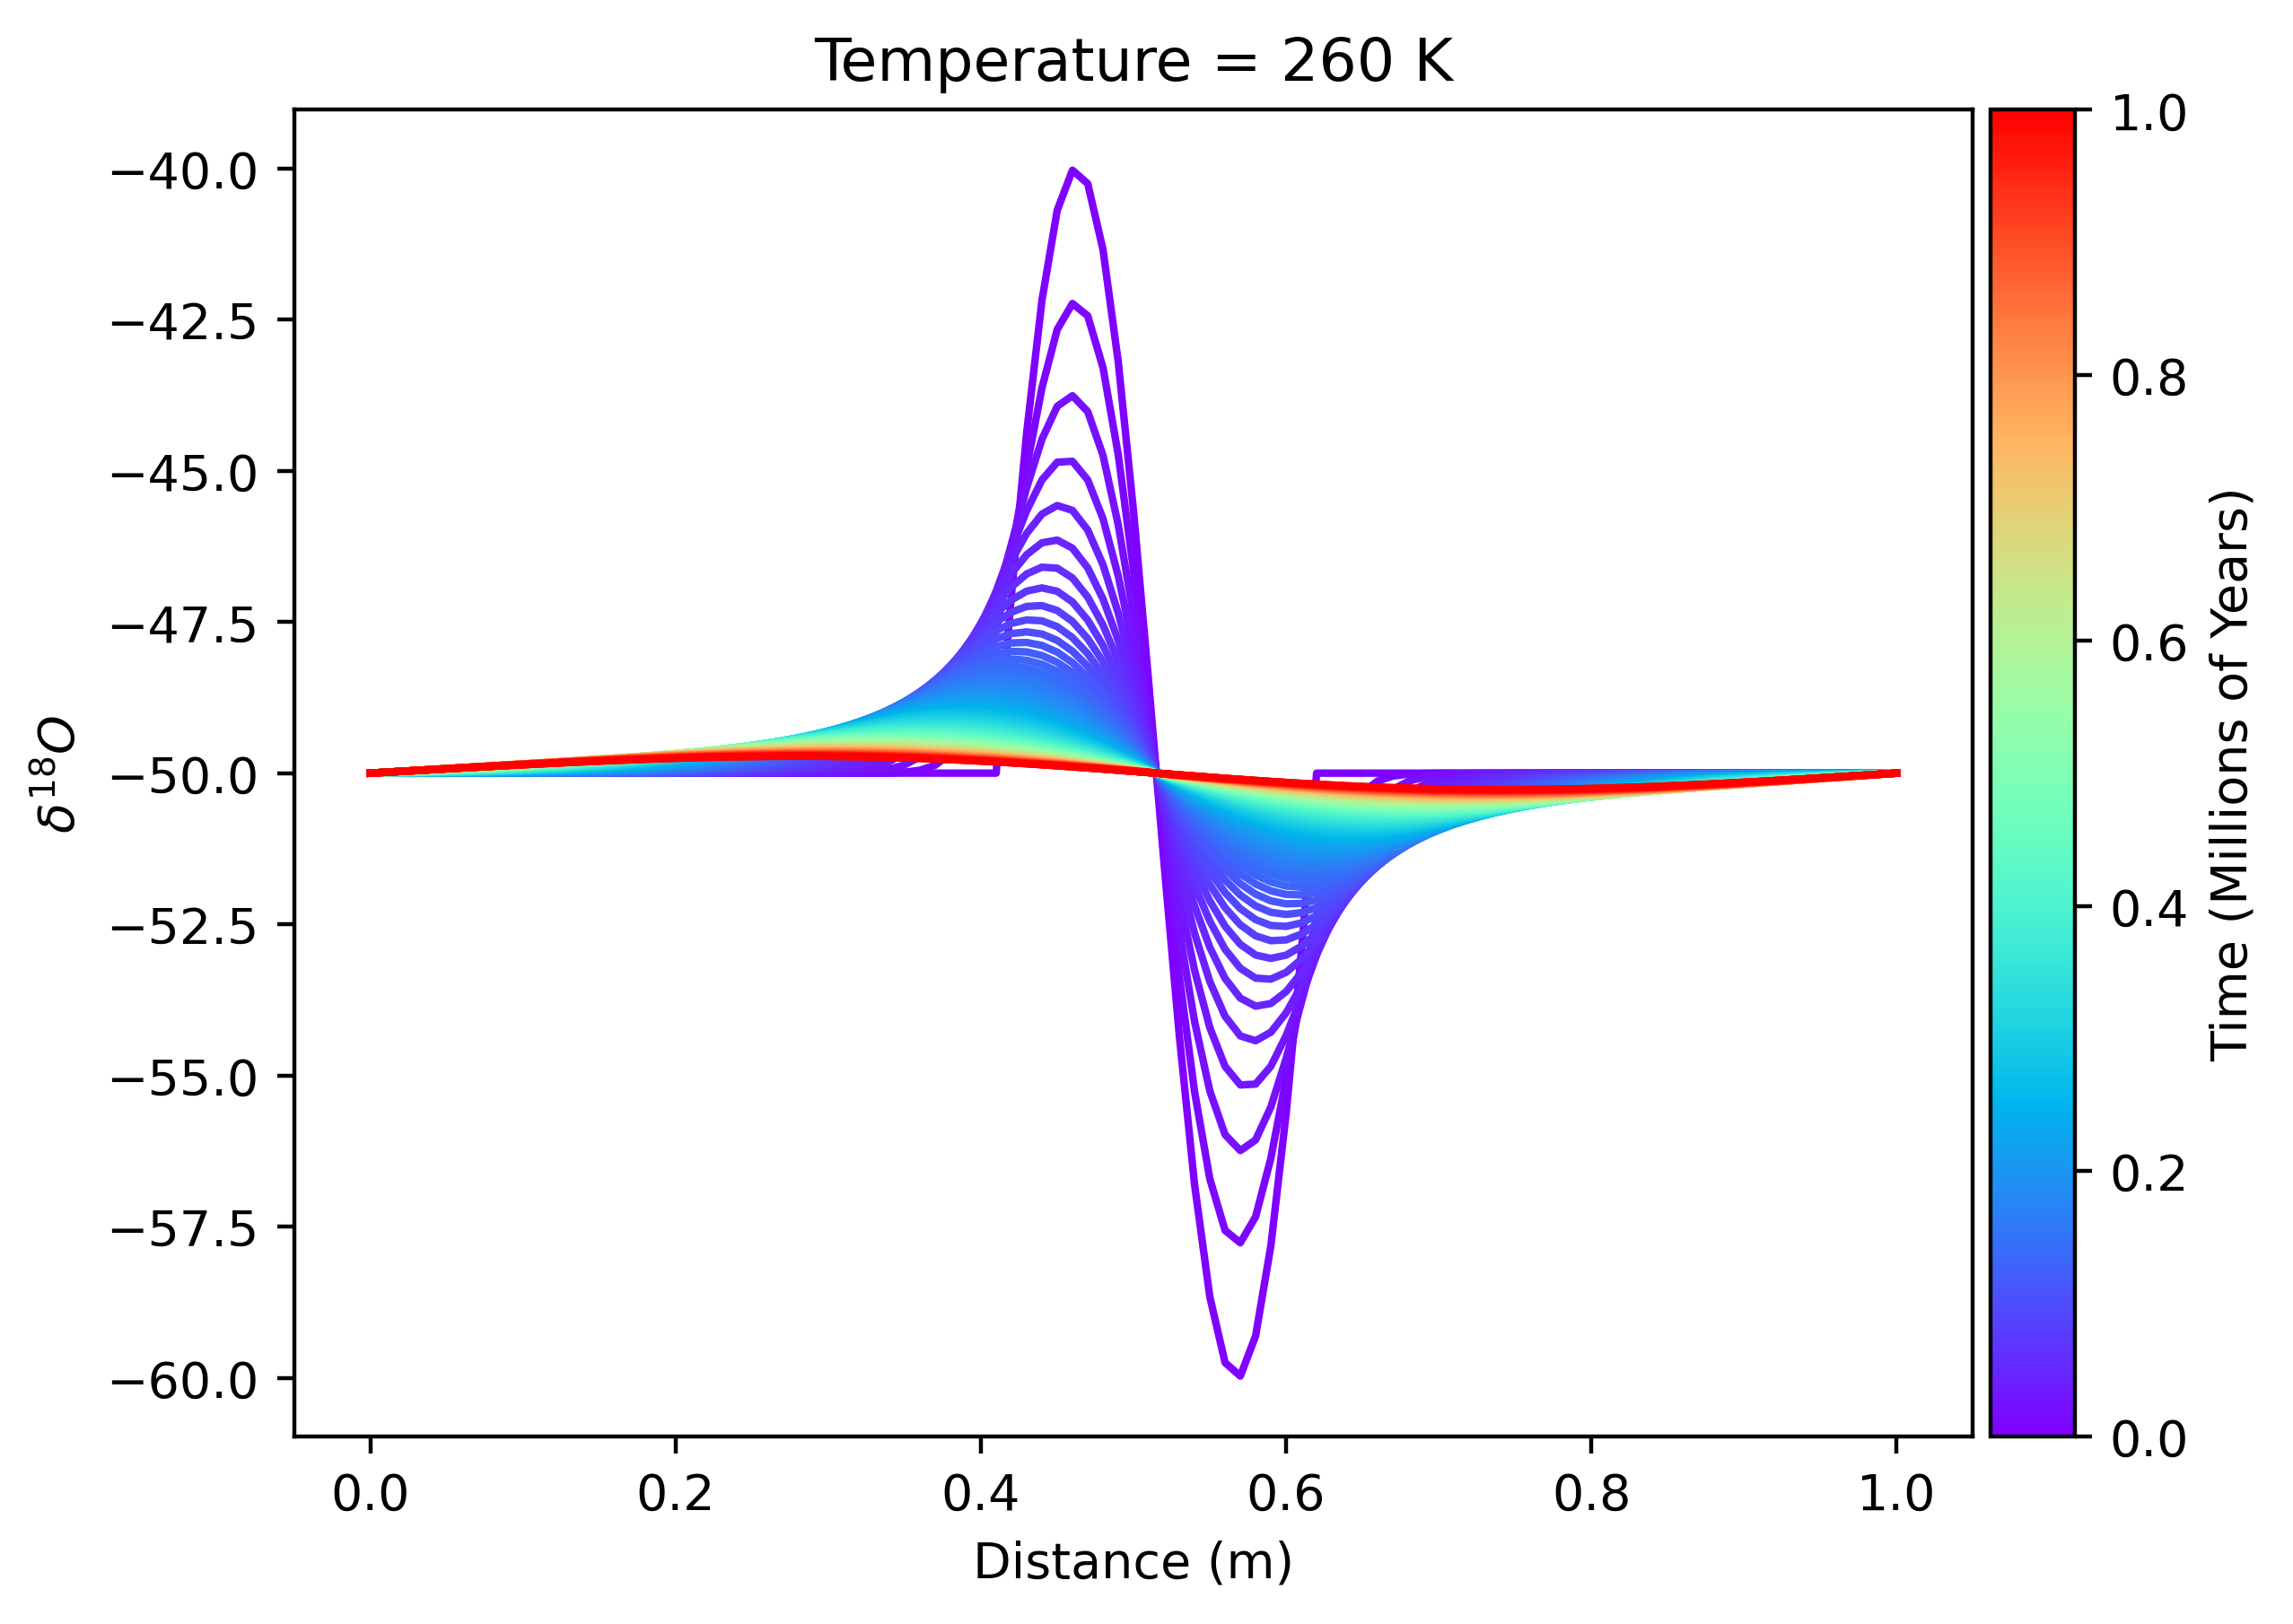

In [6]:
# make figure
fig, axs = plt.subplots(dpi=400)
axs.set_title('Temperature = '+str(T)+' K')
axs.set_ylabel(r'$\delta^{18}O$')
axs.set_xlabel('Distance (m)')

# set colormap and add colorbar
norm = matplotlib.colors.Normalize(vmin=np.min(t)*10**-6,vmax=np.max(t)*10**-6)
cmap = matplotlib.colormaps.get_cmap('rainbow')
s_m = matplotlib.cm.ScalarMappable(cmap=cmap,norm=norm)
s_m.set_array([])
divider = make_axes_locatable(axs)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(s_m,cax=cax,label='Time (Millions of Years)')

# Plot all time steps
for i in range(0,len(t),10000): # loop through all time steps
    
    # plot give time step. Shade by time. Ignore first/last point 
    axs.plot(z,run1[i,:],color=cmap(i/len(t)))


### An example of how you might automate things a bit

In [7]:
# make a list of temperatures to run
temps = [250,260,270]
amp = []

for T in temps:
    
    # Calculate diffusion coefficent (following Gkinis et al., 2014)
    D = 9.2 * 10**(-4) * math.exp(-7186/T) # units m^2/s
    
    print("For T = "+str(T)+", D = "+str(D))
    
    run = diffusion(t,z,z0,zmax,I,D)
    
    amp.append(max(run[-1,:]) - min(run[-1,:]))


For T = 250, D = 3.0229240758484015e-16
For T = 260, D = 9.131802137770452e-16
For T = 270, D = 2.5416785066654264e-15


In [8]:
amp

[1.644601650171218, 0.548675209862246, 0.07180159361265481]

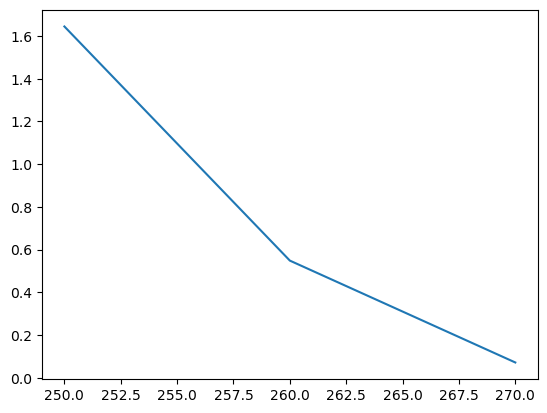

In [9]:
plt.plot(temps,amp)